# Classification IMDb using RNN
## Importing libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Cek apakah CUDA tersedia dan gunakan GPU jika memungkinkan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load IMDb Dataset
num_words = 10000  # Set the max number of words for the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)


In [ ]:
# Pad the sequences to a fixed length
maxlen = 200  # You can change this to 500 for different sequence length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [ ]:
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(device)


In [ ]:
# Define the model (Complex Deep Learning Model)
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.rnn = nn.LSTM(128, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)  # Bidirectional so we multiply by 2
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take the last time step
        out = self.fc1(out)
        out = self.fc2(out)
        return self.sigmoid(out)

In [ ]:

# Hyperparameters
input_dim = num_words  # Number of words in vocabulary
hidden_dim = 64  # Hidden layer dimensions
output_dim = 1  # Binary classification

In [ ]:
# Initialize the model, loss function, and optimizer
model = RNNModel(input_dim, hidden_dim, output_dim).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
num_epochs = 5 # Reduced number of epochs for faster training
batch_size = 32  # Increased batch size for faster training
train_loader = DataLoader(list(zip(x_train_tensor, y_train_tensor)), batch_size=batch_size, shuffle=True)


In [ ]:
# Track loss and accuracy for plotting
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions
        preds = outputs.squeeze().round()  # Round to get 0 or 1
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    train_loss.append(epoch_loss)
    train_accuracy.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/5, Loss: 0.6184, Accuracy: 0.6431
Epoch 2/5, Loss: 0.4098, Accuracy: 0.8173
Epoch 3/5, Loss: 0.2637, Accuracy: 0.8946
Epoch 4/5, Loss: 0.1926, Accuracy: 0.9260
Epoch 5/5, Loss: 0.1407, Accuracy: 0.9490


In [ ]:
device = torch.device("cpu")  # Menggunakan CPU untuk evaluasi
model.to(device)
x_test_tensor = x_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


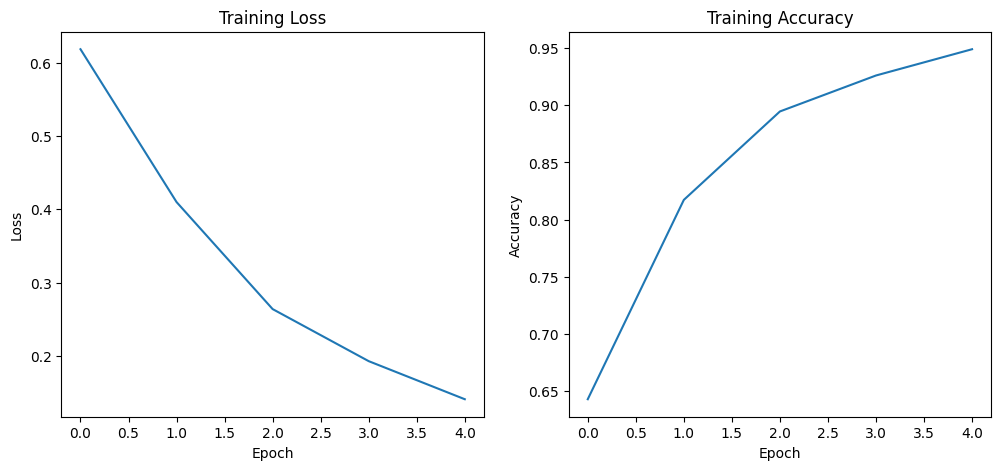

In [ ]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


In [ ]:
test_loader = DataLoader(list(zip(x_test_tensor, y_test_tensor)), batch_size=batch_size)

model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = outputs.squeeze().cpu().numpy()
        preds = np.round(probs)
        all_probs.extend(probs)
        all_preds.extend(preds)

accuracy = accuracy_score(y_test, all_preds)
precision = precision_score(y_test, all_preds)
recall = recall_score(y_test, all_preds)
f1 = f1_score(y_test, all_preds)
auc = roc_auc_score(y_test, all_probs)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test AUC: {auc:.4f}')


Test Accuracy: 0.8665
Test Precision: 0.8489
Test Recall: 0.8918
Test F1 Score: 0.8698
Test AUC: 0.9403


#**Tensorflow**

In [ ]:
# Define the model (Complex Deep Learning Model)
model = models.Sequential()
model.add(layers.Embedding(input_dim=num_words, output_dim=128, input_length=maxlen))
model.add(layers.LSTM(128, return_sequences=True, dropout=0.2))
model.add(layers.LSTM(128, dropout=0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.7160 - loss: 0.5264 - val_accuracy: 0.8652 - val_loss: 0.3418
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.8992 - loss: 0.2598 - val_accuracy: 0.8599 - val_loss: 0.3577
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9318 - loss: 0.1786 - val_accuracy: 0.8683 - val_loss: 0.3280
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9549 - loss: 0.1302 - val_accuracy: 0.8404 - val_loss: 0.4021
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.9625 - loss: 0.1091 - val_accuracy: 0.8560 - val_loss: 0.4200


In [ ]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0, 0.5, 'Loss')

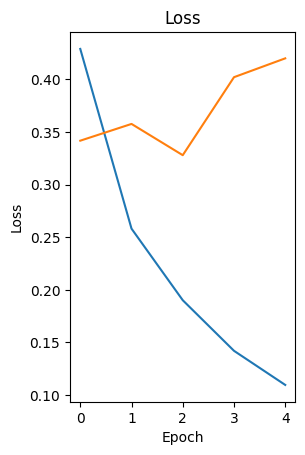

In [ ]:
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


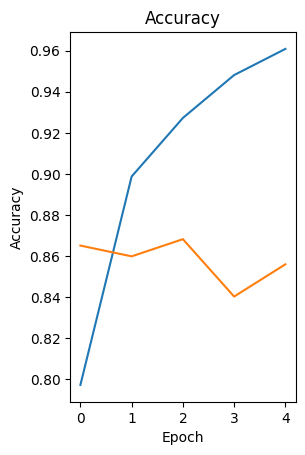

In [ ]:
# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.show()

In [ ]:
# Evaluate the model on test set
y_pred = (model.predict(x_test) > 0.5).astype('int32')



782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)


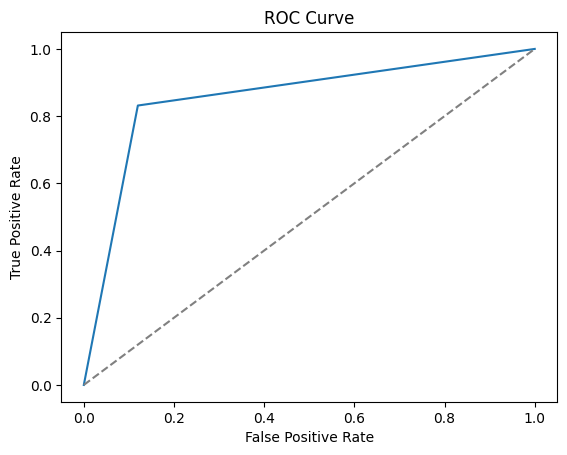

In [ ]:

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [ ]:

# Print metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test AUC: {auc:.4f}')

Test Accuracy: 0.8558
Test Precision: 0.8740
Test Recall: 0.8315
Test F1 Score: 0.8522
Test AUC: 0.8558


# Penjelasan Metrik Evaluasi Model Klasifikasi

## 1. **Akurasi (Accuracy)**
Akurasi mengukur seberapa sering model membuat prediksi yang benar dibandingkan dengan total prediksi yang dibuat.

**Persamaan**:
$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$

Dimana:
- **TP (True Positives)**: Jumlah prediksi yang benar untuk kelas positif.
- **TN (True Negatives)**: Jumlah prediksi yang benar untuk kelas negatif.
- **FP (False Positives)**: Jumlah prediksi yang salah untuk kelas positif.
- **FN (False Negatives)**: Jumlah prediksi yang salah untuk kelas negatif.

Akurasi menghitung rasio prediksi yang benar terhadap total prediksi yang dibuat oleh model.

## 2. **Presisi (Precision)**
Presisi mengukur seberapa tepat model dalam mengklasifikasikan kelas positif. Ini dihitung sebagai rasio antara prediksi positif yang benar dan semua prediksi yang diklasifikasikan sebagai positif oleh model.

**Persamaan**:
$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

Dimana:
- **TP**: True Positives (jumlah prediksi positif yang benar).
- **FP**: False Positives (jumlah prediksi positif yang salah).

Presisi mengukur **kebenaran** dari prediksi positif yang dibuat oleh model.

## 3. **Recall (Sensitivity atau True Positive Rate)**
Recall mengukur seberapa baik model dalam mendeteksi kelas positif yang sebenarnya. Ini dihitung sebagai rasio antara prediksi positif yang benar dengan jumlah keseluruhan instance yang benar-benar positif.

**Persamaan**:
$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

Dimana:
- **TP**: True Positives (jumlah prediksi positif yang benar).
- **FN**: False Negatives (jumlah prediksi negatif yang salah, tetapi seharusnya positif).

Recall mengukur **kemampuan model untuk menangkap semua kasus positif**.

## 4. **F1 Score**
F1 Score adalah rata-rata harmonis antara **presisi** dan **recall**. F1 score memberikan gambaran yang lebih baik mengenai keseimbangan antara presisi dan recall, terutama ketika data tidak seimbang (misalnya, jumlah positif jauh lebih sedikit daripada negatif).

**Persamaan**:
$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

F1 Score adalah pengukuran yang lebih baik daripada hanya menggunakan akurasi ketika data tidak seimbang.

## 5. **F1 Squared**
F1 Squared adalah kuadrat dari F1 Score. Ini memberikan bobot yang lebih besar pada nilai F1 dan mempertegas perbedaan antara model dengan nilai F1 yang hampir sama.

**Persamaan**:
$$
\text{F1 Squared} = (\text{F1 Score})^2
$$

F1 Squared lebih sensitif terhadap perubahan kecil dalam F1 score dan memberikan nilai antara 0 dan 1.

## 6. **AUC (Area Under the Curve)**
AUC (Area Under the ROC Curve) mengukur seberapa baik model dalam membedakan antara kelas positif dan negatif. Nilai AUC berkisar antara 0 dan 1, dimana 1 menunjukkan bahwa model sempurna, dan 0.5 menunjukkan model yang tidak lebih baik dari tebak-tebakan acak.

**Persamaan**:
$$
\text{AUC} = \int_0^1 \text{TPR}(t) \, \text{d}FPR(t)
$$

Dimana:
- **TPR (True Positive Rate)**: Seperti Recall, yaitu rasio instance positif yang terklasifikasikan dengan benar.
- **FPR (False Positive Rate)**: Rasio instance negatif yang salah terklasifikasikan sebagai positif.
- **t**: Titik threshold (nilai ambang batas).

AUC mengukur area di bawah kurva ROC dan memberi tahu kita bagaimana model berperforma secara keseluruhan pada berbagai nilai threshold.

## 7. **ROC Curve (Receiver Operating Characteristic Curve)**
ROC curve menggambarkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)** pada berbagai nilai threshold. ROC curve memberi gambaran bagaimana model berubah ketika kita mengubah ambang batas (threshold) dari prediksi.

**Persamaan**:
$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$
$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

Dimana:
- **TPR** adalah True Positive Rate (Recall).
- **FPR** adalah False Positive Rate (rasio instance negatif yang terklasifikasikan sebagai positif).

ROC Curve digunakan untuk **menilai kinerja model di berbagai titik threshold** dan menunjukkan trade-off antara TPR dan FPR.

## 8. **Confusion Matrix**
Confusion matrix adalah alat untuk menganalisis hasil klasifikasi model. Ini memberikan informasi tentang **True Positives (TP)**, **False Positives (FP)**, **True Negatives (TN)**, dan **False Negatives (FN)**.

**Format Confusion Matrix**:

$$
\begin{array}{|c|c|c|}
\hline
 & \text{Predicted Positive} & \text{Predicted Negative} \\
\hline
\text{Actual Positive} & \text{TP} & \text{FN} \\
\text{Actual Negative} & \text{FP} & \text{TN} \\
\hline
\end{array}
$$

- **TP**: Jumlah prediksi positif yang benar.
- **FP**: Jumlah prediksi positif yang salah.
- **TN**: Jumlah prediksi negatif yang benar.
- **FN**: Jumlah prediksi negatif yang salah.

Confusion matrix membantu kita untuk melihat **berapa banyak kesalahan** yang dibuat oleh model dalam klasifikasi.

## 9. **Precision-Recall Trade-off**
- **Precision** dan **Recall** sering kali memiliki **trade-off**: jika kita meningkatkan precision, recall cenderung menurun, dan sebaliknya. F1 Score menggabungkan kedua metrik ini untuk memberikan gambaran yang lebih seimbang.

---

## Visualisasi:
- **ROC Curve** memberikan gambaran bagaimana model bekerja pada berbagai threshold. Semakin dekat ROC curve ke sudut kiri atas, semakin baik kinerja model.
- **Confusion Matrix** memberikan gambaran lebih jelas tentang bagaimana model mengklasifikasikan berbagai contoh ke dalam kelas yang benar dan salah.
  
---

## Kesimpulan:
Setiap metrik di atas memberikan pandangan berbeda tentang seberapa baik model bekerja:
- **Akurasi** adalah metrik umum, tetapi bisa menyesatkan jika data tidak seimbang.
- **Precision** dan **Recall** berguna saat kelas positif atau negatif lebih penting.
- **F1 Score** memberikan keseimbangan antara precision dan recall.
- **AUC** dan **ROC Curve** memberikan gambaran tentang kemampuan model dalam membedakan antara kelas.
